# get data from google drive

In [0]:
content = """
fileid="1flDN4YS-_QlRZLEm9MALFZvOzyZoBntr"
filename="data0427_3.zip"
curl -c ./cookie -s -L "https://drive.google.com/uc?export=download&id=${fileid}" > /dev/null
curl -Lb ./cookie "https://drive.google.com/uc?export=download&confirm=`awk '/download/ {print $NF}' ./cookie`&id=${fileid}" -o ${filename}
"""
f = open("download.sh", "w")
f.write(content)
f.close()

In [4]:
!sh download.sh

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   388    0   388    0     0    388      0 --:--:-- --:--:-- --:--:--  3559
100  480M    0  480M    0     0   160M      0 --:--:--  0:00:03 --:--:--  184M


In [6]:
!unzip data0427_3.zip

Archive:  data0427_3.zip
replace data0427_3/.DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


In [7]:
!pip install git+git://github.com/fchollet/keras.git --upgrade

Looking in indexes: https://pypi.org/simple, https://legacy.pypi.org/simple
  Cloning git://github.com/fchollet/keras.git to /tmp/pip-req-build-qg8dxm3g
Requirement not upgraded as not directly required: numpy>=1.9.1 in /usr/local/lib/python3.6/dist-packages (from Keras==2.1.6) (1.14.2)
Requirement not upgraded as not directly required: scipy>=0.14 in /usr/local/lib/python3.6/dist-packages (from Keras==2.1.6) (0.19.1)
Requirement not upgraded as not directly required: six>=1.9.0 in /usr/local/lib/python3.6/dist-packages (from Keras==2.1.6) (1.11.0)
Requirement not upgraded as not directly required: pyyaml in /usr/local/lib/python3.6/dist-packages (from Keras==2.1.6) (3.12)
Requirement not upgraded as not directly required: h5py in /usr/local/lib/python3.6/dist-packages (from Keras==2.1.6) (2.7.1)
  Running setup.py bdist_wheel for Keras ... - \ | done
  Stored in directory: /tmp/pip-ephem-wheel-cache-tqbc29vw/wheels/dc/a7/a2/8b2d0fd23dee9c609b4c95f2b5ed27997ed17ccbeabbebfc64
Succ

# data preparation

In [0]:
import numpy as np
import keras
from keras import backend as K
from keras.models import Sequential
from keras.engine.training import Model
from keras.layers import Activation
from keras.models import load_model
from keras.layers import GlobalAveragePooling2D
from keras.layers.core import Dense, Flatten, Dropout
from keras.optimizers import Adam
from keras.metrics import categorical_crossentropy
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import *
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import itertools
import matplotlib.pyplot as plt
%matplotlib inline

In [0]:
train_path = 'data0427_3/train'
valid_path = 'data0427_3/valid'
test_path = 'data0427_3/test'

TRAIN_DATA_SIZE = 4280
VALID_DATA_SIZE = 1096
TEST_DATA_SIZE = 1096

TRAIN_BATCH_SIZE = 20
VALID_BATCH_SIZE = 8
TEST_BATCH_SIZE = 8

train_step = int(TRAIN_DATA_SIZE/TRAIN_BATCH_SIZE)
valid_step = int(VALID_DATA_SIZE/VALID_BATCH_SIZE)
test_step = int(TEST_DATA_SIZE/TEST_BATCH_SIZE)

class_labels = ['0','1','2','3','4','5','6','7','8','9','10']

EPOCHS_NUM = 5

In [20]:
train_batches = ImageDataGenerator().flow_from_directory(train_path,target_size=(224,224),classes=class_labels, batch_size=TRAIN_BATCH_SIZE)
valid_batches = ImageDataGenerator().flow_from_directory(valid_path,target_size=(224,224),classes=class_labels, batch_size=VALID_BATCH_SIZE)
test_batches = ImageDataGenerator().flow_from_directory(test_path,target_size=(224,224),classes=class_labels, batch_size=TEST_BATCH_SIZE)

Found 4280 images belonging to 11 classes.
Found 1096 images belonging to 11 classes.
Found 1096 images belonging to 11 classes.


# build and train CNN

In [21]:
# model = Sequential(
#     [Conv2D(32,(5,5), activation='relu', input_shape=(224,224,3)),Flatten(),Dense(len(class_labels),activation='softmax')]
# )

model = Sequential()

model.add(Conv2D(96, (3, 3), activation='relu', padding = 'same', input_shape=(224,224,3)))    
model.add(Dropout(0.2))

model.add(Conv2D(96, (3, 3), activation='relu', padding = 'same'))  
model.add(Conv2D(96, (3, 3), activation='relu', padding = 'same', strides = 2))    
model.add(Dropout(0.5))

model.add(Conv2D(192, (3, 3), activation='relu', padding = 'same'))    
model.add(Conv2D(192, (3, 3), activation='relu', padding = 'same'))
model.add(Conv2D(192, (3, 3), activation='relu', padding = 'same', strides = 2))    
model.add(Dropout(0.5))    

model.add(Conv2D(192, (3, 3), padding = 'same'))
model.add(Activation('relu'))
model.add(Conv2D(192, (1, 1),padding='valid'))
model.add(Activation('relu'))
model.add(Conv2D(11, (1, 1), padding='valid'))

model.add(GlobalAveragePooling2D())

model.add(Activation('softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_19 (Conv2D)           (None, 224, 224, 96)      2688      
_________________________________________________________________
dropout_7 (Dropout)          (None, 224, 224, 96)      0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 224, 224, 96)      83040     
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 112, 112, 96)      83040     
_________________________________________________________________
dropout_8 (Dropout)          (None, 112, 112, 96)      0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 112, 112, 192)     166080    
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 112, 112, 192)     331968    
__________

In [0]:
model.compile(Adam(lr=.01), loss='categorical_crossentropy',metrics=['accuracy'])

In [40]:
model.fit_generator(train_batches, steps_per_epoch=train_step, validation_data=valid_batches, validation_steps=valid_step, epochs=EPOCHS_NUM, verbose=1)

Epoch 1/5
214/214 [==============================] - 236s 1s/step - loss: 14.5726 - acc: 0.0930 - val_loss: 14.6475 - val_acc: 0.0912
Epoch 2/5
214/214 [==============================] - 236s 1s/step - loss: 14.6117 - acc: 0.0935 - val_loss: 14.6475 - val_acc: 0.0912
Epoch 3/5
 87/214 [===========>..................] - ETA: 2:07 - loss: 14.6823 - acc: 0.0891214/214 [==============================] - 236s 1s/step - loss: 14.6117 - acc: 0.0935 - val_loss: 14.6475 - val_acc: 0.0912
Epoch 4/5
214/214 [==============================] - 236s 1s/step - loss: 14.6117 - acc: 0.0935 - val_loss: 14.6475 - val_acc: 0.0912
Epoch 5/5
122/214 [================>.............] - ETA: 1:32 - loss: 14.6450 - acc: 0.0914214/214 [==============================] - 236s 1s/step - loss: 14.6117 - acc: 0.0935 - val_loss: 14.6475 - val_acc: 0.0912


# predict

In [0]:
# transfer label results from [0,0,1,0] to [2]
# def get_labels(arr):
#   labels = np.zeros( (arr.shape[0],1) )
#   for i in range(0,arr.shape[0]):
#     for j in range(0,arr.shape[1]):
#       if arr[i,j]==1:
#         labels[i,0]=j
#   return labels

def get_labels(arr):
  labels = np.zeros( (arr.shape[0],1) )
  for i in range(0,arr.shape[0]):
    row = arr[i,]
    labels[i,0]=np.where(row==np.max(row,axis=0))[0]
  return labels

In [0]:
def get_all_labels_from_batches(batches, steps):
  batches.reset()
  labels = np.zeros( (1,1) )
  for i in range(0,steps):
    cur_imgs, cur_labels = next(batches)
    cur_labels = get_labels(cur_labels)
    labels = np.row_stack((labels,cur_labels))
  labels = np.delete(labels, 0, 0)
  batches.reset()
  return labels

In [0]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [0]:
predictions = model.predict_generator(test_batches,steps=test_step, verbose=len(class_labels))
pred_labels = get_labels(predictions)

In [0]:
test_labels = get_all_labels_from_batches(test_batches, test_step)

In [44]:
accuracy_score(test_labels, pred_labels)

0.09124087591240876

Confusion matrix, without normalization
[[  0   0   0 100   0   0   0   0   0   0   0]
 [  0   0   0 100   0   0   0   0   0   0   0]
 [  0   0   0 100   0   0   0   0   0   0   0]
 [  0   0   0 100   0   0   0   0   0   0   0]
 [  0   0   0 100   0   0   0   0   0   0   0]
 [  0   0   0 100   0   0   0   0   0   0   0]
 [  0   0   0 100   0   0   0   0   0   0   0]
 [  0   0   0  96   0   0   0   0   0   0   0]
 [  0   0   0 100   0   0   0   0   0   0   0]
 [  0   0   0 100   0   0   0   0   0   0   0]
 [  0   0   0 100   0   0   0   0   0   0   0]]


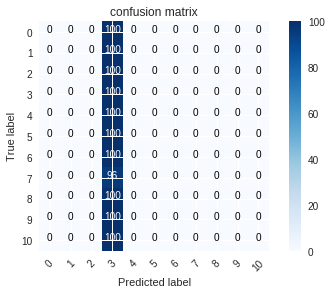

In [45]:
cm = confusion_matrix(test_labels, pred_labels)
plot_confusion_matrix(cm, classes=class_labels, title='confusion matrix')

# build vgg16 model

In [0]:
vgg16_model = keras.applications.vgg16.VGG16()

In [27]:
vgg16_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [0]:
vggmodel = Sequential()
for layer in vgg16_model.layers:
  vggmodel.add(layer)

In [91]:
vggmodel.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [92]:
vggmodel.layers.pop()

In [0]:
for layer in vggmodel.layers:
  layer.trainable = False
vggmodel.add(Dense(len(class_labels), activation = 'softmax'))

In [94]:
vggmodel.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [0]:
vggmodel.compile(Adam(lr=.0001), loss='categorical_crossentropy',metrics=['accuracy'])

In [96]:
vggmodel.fit_generator(train_batches, steps_per_epoch=train_step, validation_data=valid_batches, validation_steps=valid_step, epochs=EPOCHS_NUM, verbose=1)

Epoch 1/5
214/214 [==============================] - 92s 428ms/step - loss: 2.3720 - acc: 0.3621 - val_loss: 2.3529 - val_acc: 0.5009
Epoch 2/5
214/214 [==============================] - 80s 372ms/step - loss: 2.3366 - acc: 0.5589 - val_loss: 2.3282 - val_acc: 0.5593
Epoch 3/5
 90/214 [===========>..................] - ETA: 34s - loss: 2.3153 - acc: 0.6261214/214 [==============================] - 79s 368ms/step - loss: 2.3103 - acc: 0.6301 - val_loss: 2.3067 - val_acc: 0.5958
Epoch 4/5
214/214 [==============================] - 79s 369ms/step - loss: 2.2852 - acc: 0.6759 - val_loss: 2.2859 - val_acc: 0.6296
Epoch 5/5
125/214 [================>.............] - ETA: 24s - loss: 2.2619 - acc: 0.7224214/214 [==============================] - 79s 369ms/step - loss: 2.2597 - acc: 0.7093 - val_loss: 2.2649 - val_acc: 0.6451


In [0]:
vgg_predictions = vggmodel.predict_generator(test_batches,steps=test_step, verbose=len(class_labels))
pred_vgg_labels = get_labels(vgg_predictions)

In [98]:
accuracy_score(test_labels, pred_vgg_labels)

0.07664233576642336

Confusion matrix, without normalization
[[ 8 15  3 13  4 13 10 10  9  7  8]
 [ 5 14  2 10  8 11  9 17  4 12  8]
 [ 9 13  0  9  9 15 11  6 11 11  6]
 [ 8  8  3  8 13 14  9  7  8 13  9]
 [13 15  0  6  9 11  9 13  5 13  6]
 [ 6 10  1 13 10 10  9 10  7 14 10]
 [ 9 13  6  6  7 15  7 11  7  9 10]
 [16 11  1  9  8 15 11  7  6  4  8]
 [11 10  3  8 11 12 12  6  3 16  8]
 [12 13  0 10  7 27  8  2  9  8  4]
 [12 12  0  8 10 14 10  3  9 12 10]]


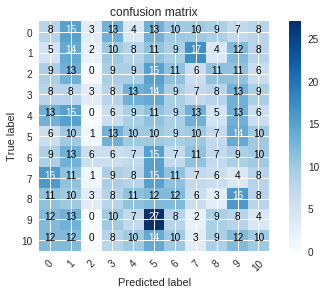

In [99]:
vgg_cm = confusion_matrix(test_labels, pred_vgg_labels)
plot_confusion_matrix(vgg_cm, classes=class_labels, title='confusion matrix')

# save/load model

In [0]:
!mkdir models

In [0]:
model.save('models/model.h5')

In [0]:
loaded_model = load_model('models/model.h5')

In [103]:
loaded_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_19 (Conv2D)           (None, 224, 224, 96)      2688      
_________________________________________________________________
dropout_7 (Dropout)          (None, 224, 224, 96)      0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 224, 224, 96)      83040     
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 112, 112, 96)      83040     
_________________________________________________________________
dropout_8 (Dropout)          (None, 112, 112, 96)      0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 112, 112, 192)     166080    
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 112, 112, 192)     331968    
__________

# inception_v3(doing)

In [0]:
# inc3_model = keras.applications.inception_v3.InceptionV3()
resv2_model = keras.applications.inception_resnet_v2.InceptionResNetV2()

In [0]:
resv2_model.summary()

In [71]:
type(inc3_model)

keras.engine.training.Model

In [0]:
resv2model = Sequential()
for layer in resv2_model.layers:
  resv2model.add(layer)

In [82]:
resv2model.layers.pop()
for layer in resv2model.layers:
  layer.trainable = False
resv2model.layers.add(Dense(len(class_labels), activation = 'softmax'))

AttributeError: ignored

In [0]:
inc3model.compile(Adam(lr=.01), loss='categorical_crossentropy',metrics=['accuracy'])
inc3model.fit_generator(train_batches, steps_per_epoch=train_step, validation_data=valid_batches, validation_steps=valid_step, epochs=EPOCHS_NUM, verbose=1)

In [0]:
inc3_predictions = inc3_model.predict_generator(test_batches,steps=test_step, verbose=len(class_labels))
pred_inc3_labels = get_labels(inc3_predictions)

In [61]:
inc3_predictions.shape

(1096, 1000)

In [59]:
accuracy_score(test_labels, pred_inc3_labels)

0.0

In [0]:
vgg_cm = confusion_matrix(test_labels, pred_vgg_labels)
plot_confusion_matrix(vgg_cm, classes=class_labels, title='confusion matrix')

In [100]:
!cd models && ls

model.h5
